In [7]:
import os
import random
import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from IPython.display import HTML, display

from pathlib import Path
!pip install pandas_path
from pandas_path import path

!pip install rasterio
import rasterio

!pip install line_profiler

import cv2
import albumentations
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.metrics import MeanIoU
import keras.backend as K
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [8]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Following the tutorial at https://www.depends-on-the-definition.com/unet-keras-segmenting-images/

## Load the training dataframe

In [10]:
img_size = 512

In [11]:
# This is where our downloaded images and metadata live locally
#DATA_PATH = Path.cwd().parent / "runtime" / "data" / "train_features"
DATA_PATH = Path.cwd().parent / "content" / "drive" / "MyDrive" / "DATA SCIENCE" / "data google colab" / "floodwater" / "train_features"
train_metadata = pd.read_csv(
    DATA_PATH / "flood-training-metadata.csv", parse_dates=["scene_start"]
)

In [12]:
train_metadata["nasadem"] = train_metadata["chip_id"] + "_nasadem"
train_metadata["change"] = train_metadata["chip_id"] + "_jrc-gsw-change"
train_metadata["extent"] = train_metadata["chip_id"] + "_jrc-gsw-extent"
train_metadata["occurrence"] = train_metadata["chip_id"] + "_jrc-gsw-occurrence"
train_metadata["recurrence"] = train_metadata["chip_id"] + "_jrc-gsw-recurrence"
train_metadata["seasonality"] = train_metadata["chip_id"] + "_jrc-gsw-seasonality"
train_metadata["transitions"] = train_metadata["chip_id"] + "_jrc-gsw-transitions"

In [13]:
#adding the path to the images and labels in the dataframe
train_metadata["feature_path"] = (str(DATA_PATH / "train_features")
    / train_metadata.image_id.path.with_suffix(".tif").path)

train_metadata["change"] = (str(DATA_PATH / "additional_features")
    / train_metadata.change.path.with_suffix(".tif").path)

train_metadata["extent"] = (str(DATA_PATH / "additional_features")
    / train_metadata.extent.path.with_suffix(".tif").path)

train_metadata["occurrence"] = (str(DATA_PATH / "additional_features")
    / train_metadata.occurrence.path.with_suffix(".tif").path)

train_metadata["recurrence"] = (str(DATA_PATH / "additional_features")
    / train_metadata.recurrence.path.with_suffix(".tif").path)

train_metadata["seasonality"] = (str(DATA_PATH / "additional_features")
    / train_metadata.seasonality.path.with_suffix(".tif").path)

train_metadata["transitions"] = (str(DATA_PATH / "additional_features")
    / train_metadata.transitions.path.with_suffix(".tif").path)

train_metadata["nasadem"] = (str(DATA_PATH / "additional_features")
    / train_metadata.nasadem.path.with_suffix(".tif").path)

train_metadata["label_path"] = (str(DATA_PATH / "train_labels")
    / train_metadata.chip_id.path.with_suffix(".tif").path)

In [14]:
train_metadata['feature_path'][0]

'/content/drive/MyDrive/DATA SCIENCE/data google colab/floodwater/train_features/train_features/awc00_vh.tif'

## Split the training data into train and test

In [15]:
random.seed(0)  # set a seed for reproducibility

# better to choose awc, qus, pxs
# Sample 3 random floods for validation set
flood_ids = train_metadata.flood_id.unique().tolist()
val_flood_ids = random.sample(flood_ids, 3)
val_flood_ids
#val_flood_ids = ['awc', 'qus', 'pxs']

['kuo', 'wvy', 'awc']

In [16]:
test = train_metadata[train_metadata.flood_id.isin(val_flood_ids)]
train = train_metadata[~train_metadata.flood_id.isin(val_flood_ids)]

In [17]:
def get_paths_by_chip(image_level_df):
    """
    Function that take as input the meta_dataframe
    and return a dataframe with the chip id and both path for vv and vh.
    """
    
    paths = []
    for chip, group in image_level_df.groupby("chip_id"):
        vv_path = group[group.polarization == "vv"]["feature_path"].values[0]
        vh_path = group[group.polarization == "vh"]["feature_path"].values[0]
        nasadem_path = group["nasadem"].values[0]
        change_path = group["change"].values[0]
        extent_path = group["extent"].values[0]
        occurrence_path = group["occurrence"].values[0]
        recurrence_path = group["recurrence"].values[0]
        seasonality_path = group["seasonality"].values[0]
        transitions_path = group["transitions"].values[0]
        paths.append([chip, vv_path, vh_path, nasadem_path, change_path, extent_path, occurrence_path, recurrence_path,
                      seasonality_path, transitions_path])
    return pd.DataFrame(paths, columns=["chip_id", "vv_path", "vh_path", "nasadem_path", "change_path", "extent_path", "occurrence_path",
                                        "recurrence_path", "seasonality_path", "transitions_path"])

In [19]:
# Separate features from labels
test_meta_x = get_paths_by_chip(test)
test_meta_y = test[["chip_id", "label_path"]].drop_duplicates().reset_index(drop=True)

train_meta_x = get_paths_by_chip(train)
train_meta_y = train[["chip_id", "label_path"]].drop_duplicates().reset_index(drop=True)

In [20]:
train_meta_x

,chip_id,vv_path,vh_path,nasadem_path,change_path,extent_path,occurrence_path,recurrence_path,seasonality_path,transitions_path
0,ayt00,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...
1,ayt01,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...
2,ayt02,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...
3,ayt03,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...
4,ayt04,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...
...,...,...,...,...,...,...,...,...,...,...
425,tnp48,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...
426,tnp49,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...
427,tnp50,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...
428,tnp51,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl...,/content/drive/MyDrive/DATA SCIENCE/data googl..

## Get the images from the train and test metadata

In [21]:
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

In [22]:
def numpy_mask(image_path):
    with rasterio.open(image_path) as img:
        metadata = img.meta
        bounds = img.bounds
        data = img.read(1)  # read a single band

    with rasterio.open(image_path) as img:
        return img.read(1, masked=True)

In [23]:
def get_images(feature_path, label_path):
    features = []
    labels = []
    masks = []

    out1 = display(progress(0, 100), display_id=True)
    out2 = display(progress(0, 100), display_id=True)

    paths = label_path['label_path'].to_list()
    nb_cols = len(paths)
    i = 0
    #load labels
    for i in range(nb_cols):
        with rasterio.open(paths[i]) as lp:
            img = lp.read(1)

        #create a list of mask for missing pixels
        mask = np.zeros(img.shape, dtype=np.uint8)
        mask[np.where(img == 255)] = 1

        labels.append(ma.array(img.astype('float32'), mask = mask))
        masks.append(mask)
        i = i + 1
        out2.update(progress((i/nb_cols)*100, 100))

    cols = ["vv_path", "vh_path", "nasadem_path", "change_path", "extent_path", "seasonality_path", "occurrence_path", "recurrence_path", "transitions_path"]
    #load features
    nb_cols = len(feature_path)
    for row in range(nb_cols) :
      images = []
      for col in cols:
        with rasterio.open(feature_path.loc[row, col]) as img:
          #apply transformation
          if(col in ["vv_path", "vh_path"]):
              #load the tif file
              images.append(ma.array(np.uint8(np.clip(img.read(1), -30, 0)*(-8.4)), mask = masks[row]))
              #print(type(images[0][0][0]))
          elif col == "nasadem_path":
              images.append(ma.array(np.uint8(np.clip(img.read(1), 0, 255)), mask = masks[row]))
          else:
              #load the tif file
              images.append(ma.array(img.read(1), mask = masks[row]))
          #apply the mask
            #img = ma.array(img, mask = masks[row])
          #stack the images in one array
          #images.append(img)
      features.append(np.stack(images, axis=-1))
      out2.update(progress((row/nb_cols)*100, 100))       
            
    return np.array(features), np.array(labels)

In [24]:
#%load_ext line_profiler
#%lprun -f get_images get_images(train_meta_x, train_meta_y)

In [25]:
train_x, train_y = get_images(train_meta_x, train_meta_y)
test_x, test_y = get_images(test_meta_x, test_meta_y)

In [26]:
(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

((430, 512, 512, 9), (430, 512, 512), (112, 512, 512, 9), (112, 512, 512))

## Image augmentation

In [27]:
random.seed(0)

transform = albumentations.Compose(
    [
        #albumentations.RandomCrop(256, 256),
        albumentations.RandomRotate90(),
        albumentations.HorizontalFlip(),
        albumentations.VerticalFlip(),
    ]
)

In [28]:
train_x_aug = []
train_y_aug = []
for i in range(len(train_x)):
  t = transform(image=train_x[i], mask=train_y[i])
  train_x_aug.append(t['image'])
  train_y_aug.append(t['mask'])

train_x_aug = np.array(train_x_aug)
train_y_aug = np.array(train_y_aug)

In [29]:
train_x_aug.shape

(430, 512, 512, 9)

## Display the images

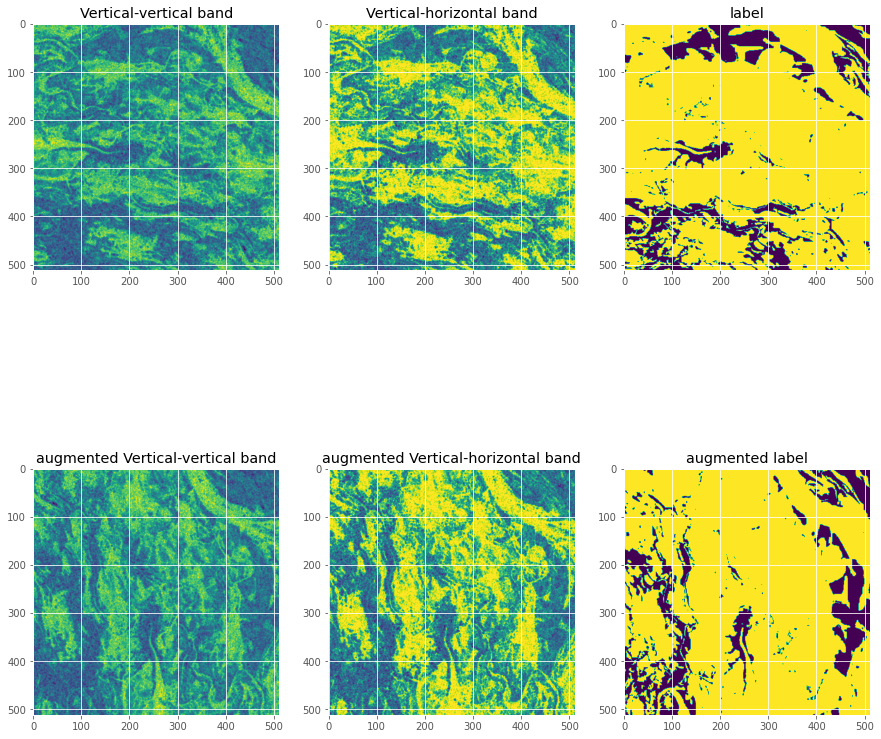

In [30]:
f, ax = plt.subplots(2, 3, figsize=(15, 15))

id = 2
#visualize radar image
ax[0][0].imshow(train_x[id, :, :, 0])
ax[0][0].set_title("Vertical-vertical band")

ax[0][1].imshow(train_x[id, :, :, 1])
ax[0][1].set_title("Vertical-horizontal band")

ax[0][2].imshow(train_y[id])
ax[0][2].set_title("label")

ax[1][0].imshow(train_x_aug[id, :, :, 0])
ax[1][0].set_title("augmented Vertical-vertical band")

ax[1][1].imshow(train_x_aug[id, :, :, 1])
ax[1][1].set_title("augmented Vertical-horizontal band")

ax[1][2].imshow(train_y_aug[id])
ax[1][2].set_title("augmented label")

plt.show()

# Concatenate training data and augmented data

In [31]:
train_x_final = np.concatenate((train_x, train_x_aug))
train_y_final = np.concatenate((train_y, train_y_aug))

In [32]:
(train_x_final.shape, train_y_final.shape)

((860, 512, 512, 9), (860, 512, 512))

# Define loss function

In [33]:
# def DiceLoss(targets, inputs, smooth=1e-6):
    
#     #flatten label and prediction tensors
#     inputs = K.flatten(inputs)
#     targets = K.flatten(targets)

#     print((inputs.shape, targets.shape))
    
#     intersection = K.sum(K.dot(targets, inputs))
#     dice = (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
#     return 1 - dice


# https://gist.github.com/wassname/7793e2058c5c9dacb5212c0ac0b18a8a
def DiceLoss(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    # y_true = y_true.astype('float32')
    # y_pred = y_pred.astype('float32')

    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return 1-((2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth))

In [34]:
# def IoULoss(targets, inputs, smooth=1e-6):
    
#     #flatten label and prediction tensors
#     inputs = K.flatten(inputs)
#     targets = K.flatten(targets)
    
#     intersection = K.sum(K.dot(targets, inputs))
#     total = K.sum(targets) + K.sum(inputs)
#     union = total - intersection
    
#     IoU = (intersection + smooth) / (union + smooth)
#     return 1 - IoU

# https://gist.github.com/wassname/f1452b748efcbeb4cb9b1d059dce6f96
def IoULoss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    
    The jaccard distance loss is usefull for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.
    
    Ref: https://en.wikipedia.org/wiki/Jaccard_index
    
    @url: https://gist.github.com/wassname/f1452b748efcbeb4cb9b1d059dce6f96
    @author: wassname
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [35]:
#Dice loss and binary cross entropy
def DiceBCELoss(targets, inputs, smooth=1e-6):    
       
    #flatten label and prediction tensors
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    BCE =  binary_crossentropy(targets, inputs)
    intersection = K.sum(K.dot(targets, inputs))    
    dice_loss = 1 - (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    Dice_BCE = BCE + dice_loss
    
    return Dice_BCE

# Unet model

In [36]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [37]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [38]:
input_img = Input((img_size, img_size, 9), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

#model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
#model.compile(optimizer=Adam(), loss=DiceLoss, metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])
model.compile(optimizer=Adam(), loss=IoULoss, metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 512, 512, 9) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 1312        img[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [39]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model_floodwater_unet_pc_augm_IOUloss.h5', verbose=1, save_best_only=True, save_weights_only=False)
]

In [40]:
type(train_x_final[0,0,0,8]), type(train_y[0,0,0])

(numpy.uint8, numpy.float32)

In [41]:
print("max train_x:", np.amax(train_x), "min train_x:", np.amin(train_x))
print("max train_x_aug:", np.amax(train_x_aug), "min train_x_aug:", np.amin(train_x_aug))
print("max test_x:", np.amax(test_x), "min test_x:", np.amin(test_x))
print("max train_y:", np.amax(train_y), "min train_y:", np.amin(train_y))
print("max test_y:", np.amax(test_y), "min test_y:", np.amin(test_y))

max train_x: 255 min train_x: 0
max train_x_aug: 255 min train_x_aug: 0
max test_x: 255 min test_x: 0
max train_y: 255.0 min train_y: 0.0
max test_y: 255.0 min test_y: 0.0


In [42]:
results = model.fit(train_x_final, train_y_final, batch_size=8, epochs=100, callbacks=callbacks,
                    validation_data=(test_x, test_y))

Epoch 1/100
108/108 [==============================] - 137s 932ms/step - loss: -265.6780 - accuracy: 0.7282 - val_loss: -661.0200 - val_accuracy: 0.7763

Epoch 00001: val_loss improved from inf to -661.02002, saving model to model_floodwater_unet_pc_augm_IOUloss.h5
Epoch 2/100
108/108 [==============================] - 95s 884ms/step - loss: -377.7687 - accuracy: 0.8125 - val_loss: -721.8292 - val_accuracy: 0.8908

Epoch 00002: val_loss improved from -661.02002 to -721.82916, saving model to model_floodwater_unet_pc_augm_IOUloss.h5
Epoch 3/100
108/108 [==============================] - 97s 900ms/step - loss: -404.9935 - accuracy: 0.8530 - val_loss: -569.5098 - val_accuracy: 0.9102

Epoch 00003: val_loss did not improve from -721.82916
Epoch 4/100
108/108 [==============================] - 96s 887ms/step - loss: -411.7268 - accuracy: 0.8215 - val_loss: -761.7842 - val_accuracy: 0.7158

Epoch 00004: val_loss improved from -721.82916 to -761.78418, saving model to model_floodwater_unet_pc

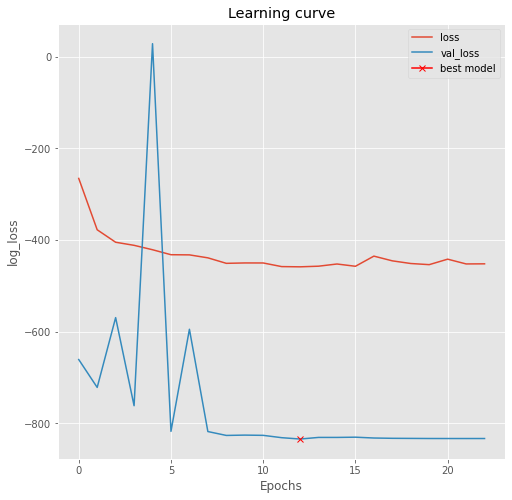

In [43]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [ ]:
# Load best model
model.load_weights('model_floodwater_unet_pc_augm_IOUloss.h5')

In [ ]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(test_x, test_y, verbose=1)

## Predict output

In [ ]:
# Predict on train, val and test
preds_train = model.predict(train_x, verbose=1)
preds_val = model.predict(test_x, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [ ]:
for id in range(100):
  f, ax = plt.subplots(1, 3, figsize=(15, 15))
  #visualize radar image   x[:, :, 0]
  ax[0].imshow(test_x[id][:, :, 0])
  ax[0].set_title("Vertical-vertical band")

  label = test_y[id]
  label[label == 255] = 1
  ax[1].imshow(label, "gray")
  ax[1].set_title("label")

  pred = preds_val_t[id][:, :, 0]
  ax[2].imshow(pred, "gray")
  ax[2].set_title("prediction")
  plt.show()

In [ ]:
for id in range(100):
  f, ax = plt.subplots(1, 3, figsize=(15, 15))
  #visualize radar image   x[:, :, 0]
  ax[0].imshow(train_x[id][:, :, 0])
  ax[0].set_title("Vertical-vertical band")

  label = train_y[id]
  label[label == 255] = 1
  ax[1].imshow(label, "gray")
  ax[1].set_title("label")

  pred = preds_train_t[id][:, :, 0]
  ax[2].imshow(pred, "gray")
  ax[2].set_title("prediction")

  plt.show()